## Training

In [58]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

global image_h
global image_w
global num_landmarks

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*.jpg")))
    train_y = sorted(glob(os.path.join(path, "train", "landmarks", "*.txt")))

    valid_x = sorted(glob(os.path.join(path, "val", "images", "*.jpg")))
    valid_y = sorted(glob(os.path.join(path, "val", "landmarks", "*.txt")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.jpg")))
    test_y = sorted(glob(os.path.join(path, "test", "landmarks", "*.txt")))

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image_lankmarks(image_path, landmark_path):
    """ Image """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    h, w, _ = image.shape
    image = cv2.resize(image, (image_w, image_h))
    image = image/255.0
    image = image.astype(np.float32)

    """ Lankmarks """
    data = open(landmark_path, "r").read()
    lankmarks = []

    for line in data.strip().split("\n")[1:]:
        x, y = line.split(" ")
        x = float(x)/w
        y = float(y)/h

        lankmarks.append(x)
        lankmarks.append(y)

    lankmarks = np.array(lankmarks, dtype=np.float32)

    return image, lankmarks

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image, landmarks = read_image_lankmarks(x, y)
        return image, landmarks

    image, landmarks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    image.set_shape([image_h, image_w, 3])
    landmarks.set_shape([num_landmarks * 2])

    return image, landmarks

def tf_dataset(x, y, batch=8):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.shuffle(buffer_size=5000).map(preprocess)
    ds = ds.batch(batch).prefetch(2)
    return ds

def build_model(input_shape, num_landmarks):
    inputs = L.Input(input_shape)

    backbone = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs, alpha=0.5)
    backbone.trainable = True

    x = backbone.output
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dropout(0.2)(x)
    outputs = L.Dense(num_landmarks*2, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs, outputs)
    return model

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    image_h = 512
    image_w = 512
    num_landmarks = 106
    input_shape = (image_h, image_w, 3)
    batch_size = 4
    lr = 1e-3
    num_epochs = 20

    """ Paths """
    dataset_path = "dataset"
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

    """ Loading the dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_x)}")
    print("")

    """ Dataset Pipeline """
    train_ds = tf_dataset(train_x, train_y, batch=batch_size)
    valid_ds = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_model(input_shape, num_landmarks)
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr))

    """ Training """
    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path, append=True),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

    model.fit(train_ds,
        validation_data=valid_ds,
        epochs=num_epochs,
        callbacks=callbacks
    )



### ...


Train: 1112/1112 - Valid: 384/384 - Test: 592/592



C:\Users\Akashi\AppData\Local\Temp\ipykernel_19096\3671966413.py:80: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs, alpha=0.5)


Epoch 1/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - loss: 0.6710
Epoch 1: val_loss improved from None to 1.03703, saving model to files\model.h5


278/278 ━━━━━━━━━━━━━━━━━━━━ 196s 636ms/step - loss: 0.6664 - val_loss: 1.0370 - learning_rate: 0.0010
Epoch 2/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 0.6634
Epoch 2: val_loss improved from 1.03703 to 0.94629, saving model to files\model.h5


278/278 ━━━━━━━━━━━━━━━━━━━━ 165s 595ms/step - loss: 0.6629 - val_loss: 0.9463 - learning_rate: 0.0010
Epoch 3/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 0.6619
Epoch 3: val_loss improved from 0.94629 to 0.87937, saving model to files\model.h5


278/278 ━━━━━━━━━━━━━━━━━━━━ 165s 592ms/step - loss: 0.6620 - val_loss: 0.8794 - learning_rate: 0.0010
Epoch 4/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 0.6604
Epoch 4: val_loss improved from 0.87937 to 0.81117, saving model to files\model.h5


278/278 ━━━━━━━━━━━━━━━━━━━━ 164s 588ms/step - loss: 0.6607 - val_loss: 0.8112 - learning_rate: 0.0010
Epoch 5/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 0.6601
Epoch 5: val_loss improved from 0.81117 to 0.67415, saving model to files\model.h5


278/278 ━━━━━━━━━━━━━━━━━━━━ 163s 587ms/step - loss: 0.6602 - val_loss: 0.6742 - learning_rate: 0.0010
Epoch 6/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 0.6602
Epoch 6: val_loss did not improve from 0.67415
278/278 ━━━━━━━━━━━━━━━━━━━━ 163s 585ms/step - loss: 0.6597 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 7/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - loss: 0.6590
Epoch 7: val_loss did not improve from 0.67415
278/278 ━━━━━━━━━━━━━━━━━━━━ 164s 589ms/step - loss: 0.6593 - val_loss: 0.7139 - learning_rate: 0.0010
Epoch 8/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 0.6594
Epoch 8: val_loss did not improve from 0.67415
278/278 ━━━━━━━━━━━━━━━━━━━━ 163s 585ms/step - loss: 0.6593 - val_loss: 0.7051 - learning_rate: 0.0010
Epoch 9/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 0.6590
Epoch 9: val_loss did not improve from 0.67415
278/278 ━━━━━━━━━━━━━━━━━━━━ 162s 582ms/step - loss: 0.6591 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 10/20
278/278 ━

278/278 ━━━━━━━━━━━━━━━━━━━━ 162s 583ms/step - loss: 0.6591 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 11/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 0.6589
Epoch 11: val_loss did not improve from 0.67291
278/278 ━━━━━━━━━━━━━━━━━━━━ 162s 582ms/step - loss: 0.6588 - val_loss: 0.6744 - learning_rate: 0.0010
Epoch 12/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 0.6585
Epoch 12: val_loss improved from 0.67291 to 0.66598, saving model to files\model.h5


278/278 ━━━━━━━━━━━━━━━━━━━━ 162s 584ms/step - loss: 0.6587 - val_loss: 0.6660 - learning_rate: 0.0010
Epoch 13/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 0.6582
Epoch 13: val_loss did not improve from 0.66598
278/278 ━━━━━━━━━━━━━━━━━━━━ 162s 582ms/step - loss: 0.6588 - val_loss: 0.6673 - learning_rate: 0.0010
Epoch 14/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 0.6590
Epoch 14: val_loss did not improve from 0.66598
278/278 ━━━━━━━━━━━━━━━━━━━━ 162s 581ms/step - loss: 0.6586 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 15/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - loss: 0.6587
Epoch 15: val_loss did not improve from 0.66598
278/278 ━━━━━━━━━━━━━━━━━━━━ 161s 579ms/step - loss: 0.6585 - val_loss: 0.6740 - learning_rate: 0.0010
Epoch 16/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 0.6586
Epoch 16: val_loss did not improve from 0.66598
278/278 ━━━━━━━━━━━━━━━━━━━━ 162s 581ms/step - loss: 0.6591 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 17/20
2

278/278 ━━━━━━━━━━━━━━━━━━━━ 162s 583ms/step - loss: 0.6583 - val_loss: 0.6615 - learning_rate: 1.0000e-04
Epoch 19/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 0.6579
Epoch 19: val_loss improved from 0.66153 to 0.65959, saving model to files\model.h5


278/278 ━━━━━━━━━━━━━━━━━━━━ 162s 581ms/step - loss: 0.6582 - val_loss: 0.6596 - learning_rate: 1.0000e-04
Epoch 20/20
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 0.6584
Epoch 20: val_loss improved from 0.65959 to 0.65918, saving model to files\model.h5


278/278 ━━━━━━━━━━━━━━━━━━━━ 162s 582ms/step - loss: 0.6582 - val_loss: 0.6592 - learning_rate: 1.0000e-04


## Testing for all the images form train,test,val

In [59]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
#from train import create_dir, load_dataset

global image_h
global image_w
global num_landmarks

def plot_lankmarks(image, landmarks):
    h, w, _ = image.shape
    radius = int(h * 0.005)

    for i in range(0, len(landmarks), 2):
        x = int(landmarks[i] * w)
        y = int(landmarks[i+1] * h)

        image = cv2.circle(image, (x, y), radius, (255, 0, 0), -1)

    return image

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Hyperparameters """
    image_h = 512
    image_w = 512
    num_landmarks = 106

    """ Paths """
    dataset_path = "LaPa"
    model_path = os.path.join("files", "model.h5")

    """ Loading the dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_x)}")
    print("")

    """ Load the model """
    model = tf.keras.models.load_model(model_path)
    # model.summary()

    """ Prediction """
    count=0
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image_x = image
        image = cv2.resize(image, (image_w, image_h))
        image = image/255.0 ## (512, 512, 3)
        image = np.expand_dims(image, axis=0) ## (1, 512, 512, 3)
        image = image.astype(np.float32)

        """ Landmarks """
        data = open(y, "r").read()
        landmarks = []
        for line in data.strip().split("\n")[1:]:
            x, y = line.split(" ")
            x = float(x)/image_x.shape[1]
            y = float(y)/image_x.shape[0]

            landmarks.append(x)
            landmarks.append(y)

        landmarks = np.array(landmarks, dtype=np.float32)

        """ Prediction """
        pred = model.predict(image, verbose=0)[0]
        pred = pred.astype(np.float32)

        """ Saving the results """
        gt_landmarks = plot_lankmarks(image_x.copy(), landmarks)
        pred_landmarks = plot_lankmarks(image_x.copy(), pred)
        line = np.ones((image_x.shape[0], 10, 3)) * 255

        cat_images = np.concatenate([gt_landmarks, line, pred_landmarks], axis=1)
        cv2.imwrite(f"results/img{count}.png", cat_images)
        count+=1






    ## ...


Train: 18168/18168 - Valid: 2000/2000 - Test: 2000/2000



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:58<00:00,  5.58it/s]


### Testing for Single Image

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step


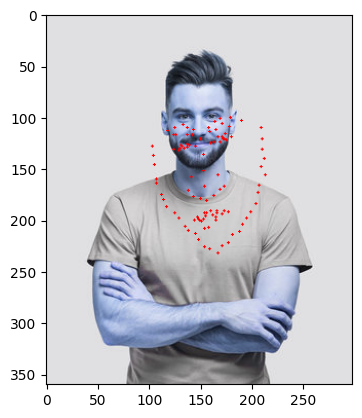


Prediction complete. Result saved to: results/predicted_face.png


In [60]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

# Define global variables used by the prediction logic
image_h = 512
image_w = 512
num_landmarks = 106

# The create_dir function is needed but not defined in your snippet, so I'll include a simple version
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def plot_lankmarks(image, landmarks):
    h, w, _ = image.shape
    # Scale the radius based on the image size
    radius = int(h * 0.005)

    # Note: landmarks must be denormalized (0-1) before plotting.
    # The original code passes normalized landmarks to this function.
    # To plot correctly, we assume the input 'landmarks' are normalized (0 to 1).
    
    for i in range(0, len(landmarks), 2):
        # Denormalize x and y back to pixel coordinates
        x = int(landmarks[i] * w)
        y = int(landmarks[i+1] * h)

        image = cv2.circle(image, (x, y), radius, (255, 0, 0), -1)

    return image

# ----------------------------------------------------------------------
# MAIN PREDICTION LOGIC
# ----------------------------------------------------------------------

if __name__ == "__main__":
    
    # ----------------------------------
    # ⚠️ Environment/Config Setup ⚠️
    # MUST run before any TF operation for cuDNN/VRAM stability
    # ----------------------------------
    # Set XLA flag to handle cuDNN profiling errors (recommended workaround)
    os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'
    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Enable memory growth (MUST be set early)
            tf.config.experimental.set_memory_growth(gpus[0], True)
            print("GPU memory growth enabled.")
        except RuntimeError as e:
            print(e)
            
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Hyperparameters (Used for resizing/denormalization) """
    # Set these to the values used during model training
    image_h = 512
    image_w = 512
    num_landmarks = 106

    """ Paths (Single Image Input) """
    # **CHANGE THIS TO YOUR DESIRED IMAGE PATH**
    input_image_path = "face.jpg" 
    model_path = os.path.join("files", "model.h5")
    
    # Check if the image exists
    if not os.path.exists(input_image_path):
        print(f"Error: Input image not found at '{input_image_path}'")
        exit()

    """ Load the model """
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")

    # ----------------------------------
    # 1. Reading and Preprocessing
    # ----------------------------------
    
    # Extract name for saving
    name = os.path.splitext(os.path.basename(input_image_path))[0]

    """ Reading the image """
    original_image = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    
    # Check for successful load
    if original_image is None:
        print(f"Error loading image: {input_image_path}")
        exit()
        
    image_for_model = cv2.resize(original_image, (image_w, image_h))
    
    # Normalize pixel values (0 to 1)
    image_for_model = image_for_model / 255.0 
    
    # Create a batch of 1: (1, H, W, C)
    image_for_model = np.expand_dims(image_for_model, axis=0) 
    image_for_model = image_for_model.astype(np.float32)

    # ----------------------------------
    # 2. Prediction
    # ----------------------------------
    
    # Get the 1D array of normalized predicted landmarks
    # Shape is (1, NUM_LANDMARKS * 2), taking [0] gives (NUM_LANDMARKS * 2,)
    pred_normalized = model.predict(image_for_model, verbose=1)[0]
    pred_normalized = pred_normalized.astype(np.float32)

    # ----------------------------------
    # 3. Visualization and Saving
    # ----------------------------------
    
    # Use the original image for the output visualization
    final_image = original_image.copy()

    # Pass the normalized predicted landmarks (0-1) to the plot function.
    # The plot_lankmarks function will denormalize them internally using h/w.
    pred_landmarks_image = plot_lankmarks(final_image, pred_normalized)
    
    # Save the result
    output_filename = f"results/predicted_{name}.png"
    cv2.imwrite(output_filename, pred_landmarks_image)
    plt.imshow(pred_landmarks_image)
    plt.show()

    print(f"\nPrediction complete. Result saved to: {output_filename}")

### Testing using WebCam

In [61]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # Suppress TensorFlow logging

import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt # Matplotlib won't be used for live feed, but we keep it imported

# --- Configuration ---
# Ensure these match the size and output of your trained model
image_h = 512
image_w = 512
num_landmarks = 106
MODEL_PATH = os.path.join("files", "model.h5")
WEBCAM_ID = 0 # Usually 0 for the default camera

# --- Helper Function ---

def plot_lankmarks(image, landmarks):
    """Plots normalized landmarks (0-1) onto the image."""
    h, w, _ = image.shape
    # Scale the radius based on the image size, adjusted for visibility
    radius = int(h * 0.005)
    
    # Plotting color is BGR (0, 0, 255) -> Red dot
    
    for i in range(0, len(landmarks), 2):
        # Denormalize x and y back to pixel coordinates
        x = int(landmarks[i] * w)
        y = int(landmarks[i+1] * h)

        image = cv2.circle(image, (x, y), radius, (0, 0, 255), -1) 

    return image

# ----------------------------------------------------------------------
# MAIN EXECUTION LOGIC
# ----------------------------------------------------------------------

if __name__ == "__main__":
    
    """ Load the model """
    try:
        model = tf.keras.models.load_model(MODEL_PATH)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}")
        exit()

    """ Initialize Webcam """
    cap = cv2.VideoCapture(WEBCAM_ID)
    if not cap.isOpened():
        print(f"Error: Could not open webcam with ID {WEBCAM_ID}. Check connections.")
        exit()

    print("\n--- Starting Live Prediction. Press 'q' to exit. ---")
    
    while True:
        # 1. Read Frame from Webcam
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break
        
        # We work on a copy of the frame
        original_frame = frame.copy()
        
        # 2. Preprocessing for Model Input
        image_for_model = cv2.resize(original_frame, (image_w, image_h))
        image_for_model = image_for_model / 255.0  # Normalize to 0-1
        # Add batch dimension and convert to float32
        image_for_model = np.expand_dims(image_for_model, axis=0).astype(np.float32)

        # 3. Prediction
        # verbose=0 to prevent prediction output from cluttering the console every frame
        pred_normalized = model.predict(image_for_model, verbose=0)[0]
        pred_normalized = pred_normalized.astype(np.float32)

        # 4. Visualization
        # Plot the predicted landmarks onto the original-sized frame
        result_frame = plot_lankmarks(original_frame, pred_normalized)
        
        # 5. Display Result
        cv2.imshow("Live Landmark Prediction", result_frame)

        # Exit loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Cleanup
    cap.release()
    cv2.destroyAllWindows()
    print("\nLive prediction stopped.")

Model loaded successfully.

--- Starting Live Prediction. Press 'q' to exit. ---

Live prediction stopped.
